<h2><b>pyLIQTR: Block Encodings</b></h2>
<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

<h3><u>1. Overview</u></h3>

`pyLIQTR` now provides extensible support for block encodings through the `BlockEncoding` gate.  This `cirq-ft` compliant class has also been used to construct several reference encodings.   These include Pauli-string based LCU as well as optimized encodings for both the Fermi-Hubbard model and translationally-invarant (i.e., periodic) systems of fermions.

This notebook gives a preliminary accounting of these methods through pedagogical examples.

<hr>

In [1]:
import numpy    as  np
import cirq     as  cirq
import cirq_ft  as  cirq_ft

import cirq_ft.infra.testing as cirq_cqt


from pyLIQTR.BlockEncodings.BlockEncoding       import   BlockEncoding
from pyLIQTR.BlockEncodings.getEncoding         import   getEncoding
from pyLIQTR.BlockEncodings                     import   VALID_ENCODINGS

from pyLIQTR.utils.circuit_decomposition        import  circuit_decompose_multi

from cirq_ft.infra.jupyter_tools                import svg_circuit

from pyLIQTR.ProblemInstances.LatticeInstance   import   LatticeInstance

from pyLIQTR.ProblemInstances.spin_models       import   Transverse_Field_Ising, Heisenberg
from pyLIQTR.ProblemInstances.fermionic_models  import   FermiHubbard


from pyLIQTR.clam.lattice_definitions           import    SquareLattice, TriangularLattice

## Resource analysis
##
from   pyLIQTR.utils.resource_analysis                        import   estimate_resources

<h3><u>2. Getting Started</u></h3>

`pyLIQTR`'s  supported encodings are specified by members of `VALID_ENCODINGS`

In [2]:
dir(VALID_ENCODINGS)[0:4]

['FermiHubbardSquare', 'Fermionic', 'LinearT', 'PauliLCU']

Our current methods include:

<ol>
<li> <b>FermiHubbardSquare</b> - Optimized encoding for the Fermi-Hubbard model on two-dimensional, periodic square lattices (see Fermi-Hubbard tutorials).</li>
<li> <b>LinearT</b> - Block encoding for periodic systems of fermions, with T-complexity that scales linearly in the number of orbitals (see periodic electronic structure tutorials).</li>
<li> <b>PauliLCU</b> - General encoding for any operator that can be decomposed as a linear combination of unitaries (see Heisenberg and arbitrary spin model tutorials). </li>
<ol>

This object is  used to fetch the desired encoding via `getEncoding`.  We demonstrate this in our following example.

<h5><b><u>2.1. Transverse-field Ising Model via PauliLCU</u></b></h5>


The `PauliLCU`` encoding can handle any operator that decomposes as a linear combination of unitaries:

\begin{equation} 
\Lambda = \sum \alpha_i \Lambda_i
\end{equation}

where $\alpha_i \in \mathbb{R}$ and $\Lambda_i$ is a unitary operator.  This is ideal for general spin Hamiltonians, as we demonstrate for the transverse-field Ising model in a spin basis:

\begin{equation}
H = J\sum_{i,j} Z_i \otimes Z_j + \sum_i (h Z_i + g  X_i)
\end{equation}

m

We begin by creating a  `Transverse_Field_Ising` problem instance on a $3 \times 3$ square lattice:

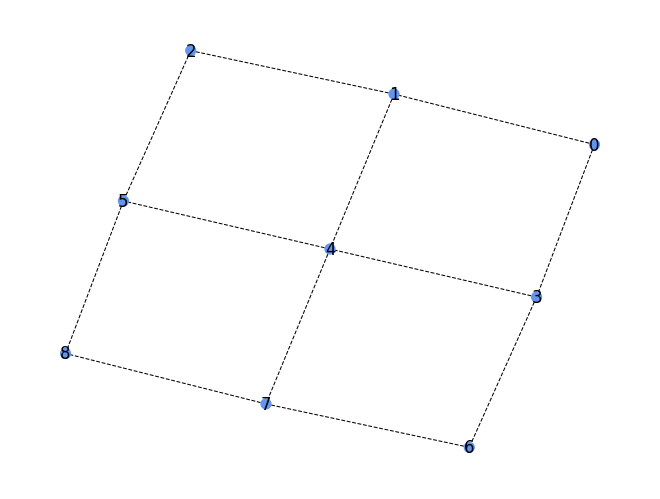

In [3]:
model            =  Transverse_Field_Ising(shape=(3,3),cell=SquareLattice)
model.draw_lattice()

The `getEncoding` helper function can be used to grab a block encoding of a type specified from`VALD_ENCODINGS`:

In [4]:
dir(VALID_ENCODINGS)[0:4]

['FermiHubbardSquare', 'Fermionic', 'LinearT', 'PauliLCU']

The encoding class is obtained via:

In [5]:
block_encoding   =  getEncoding(VALID_ENCODINGS.PauliLCU)

This can be instantiated for the model `model` via:

In [6]:
block_encoding   =  getEncoding(VALID_ENCODINGS.PauliLCU)(model)

or

In [7]:
block_encoding   =  getEncoding(VALID_ENCODINGS.PauliLCU,instance=model)

The encoding acts on the following qubits:

In [8]:
block_encoding.all_qubits

[cirq.NamedQubit('selection0'),
 cirq.NamedQubit('selection1'),
 cirq.NamedQubit('selection2'),
 cirq.NamedQubit('selection3'),
 cirq.NamedQubit('selection4'),
 cirq.NamedQubit('target0'),
 cirq.NamedQubit('target1'),
 cirq.NamedQubit('target2'),
 cirq.NamedQubit('target3'),
 cirq.NamedQubit('target4'),
 cirq.NamedQubit('target5'),
 cirq.NamedQubit('target6'),
 cirq.NamedQubit('target7'),
 cirq.NamedQubit('target8'),
 cirq.ops.CleanQubit(0),
 cirq.ops.CleanQubit(1),
 cirq.ops.CleanQubit(2),
 cirq.ops.CleanQubit(3)]

We can grab a circuit containing this encoding:

In [9]:
block_encoding.circuit

selection0: ───PauliStringLCU───
               │
selection1: ───selection────────
               │
selection2: ───selection────────
               │
selection3: ───selection────────
               │
selection4: ───selection────────
               │
target0: ──────target───────────
               │
target1: ──────target───────────
               │
target2: ──────target───────────
               │
target3: ──────target───────────
               │
target4: ──────target───────────
               │
target5: ──────target───────────
               │
target6: ──────target───────────
               │
target7: ──────target───────────
               │
target8: ──────target───────────

Decomposing this one level reveals that `PauliLCU` is built using a $\text{Prepare}-\text{Select}-\text{Prepare}^{-1}$ scheme:

In [10]:
circuit_decompose_multi(block_encoding.circuit,1)

selection0: ───prepare_pauli_lcu───In──────────────prepare_pauli_lcu───
               │                   │               │
selection1: ───selection───────────In──────────────selection───────────
               │                   │               │
selection2: ───selection───────────In──────────────selection───────────
               │                   │               │
selection3: ───selection───────────In──────────────selection───────────
               │                   │               │
selection4: ───selection───────────In──────────────selection^-1────────
                                   │
target0: ──────────────────────────GenericSelect───────────────────────
                                   │
target1: ──────────────────────────GenericSelect───────────────────────
                                   │
target2: ──────────────────────────GenericSelect───────────────────────
                                   │
target3: ──────────────────────────GenericSelect───────────────────────
                                   │
target4: ──────────────────────────GenericSelect───────────────────────
                                   │
target5: ──────────────────────────GenericSelect───────────────────────
                                   │
target6: ──────────────────────────GenericSelect───────────────────────
                                   │
target7: ──────────────────────────GenericSelect───────────────────────
                                   │
target8: ──────────────────────────GenericSelect───────────────────────

We can also find the resources required for this block encoding, such as the $T$-complexity and the number of logical qubits:

In [11]:
estimate_resources(block_encoding)

{'LogicalQubits': 14, 'T': 6712, 'Clifford': 13743}

A controlled version of this encoding is obtained by using the `control_val` keyword to specify the condition value for the control:

In [12]:
encoding       =  getEncoding(VALID_ENCODINGS.PauliLCU,instance=model)

In [13]:
circuit_decompose_multi(block_encoding.circuit,1)

selection0: ───prepare_pauli_lcu───In──────────────prepare_pauli_lcu───
               │                   │               │
selection1: ───selection───────────In──────────────selection───────────
               │                   │               │
selection2: ───selection───────────In──────────────selection───────────
               │                   │               │
selection3: ───selection───────────In──────────────selection───────────
               │                   │               │
selection4: ───selection───────────In──────────────selection^-1────────
                                   │
target0: ──────────────────────────GenericSelect───────────────────────
                                   │
target1: ──────────────────────────GenericSelect───────────────────────
                                   │
target2: ──────────────────────────GenericSelect───────────────────────
                                   │
target3: ──────────────────────────GenericSelect───────────────────────
                                   │
target4: ──────────────────────────GenericSelect───────────────────────
                                   │
target5: ──────────────────────────GenericSelect───────────────────────
                                   │
target6: ──────────────────────────GenericSelect───────────────────────
                                   │
target7: ──────────────────────────GenericSelect───────────────────────
                                   │
target8: ──────────────────────────GenericSelect───────────────────────

<h5><b><u>2.2. Fermi-Hubbard Model via FermiHubbardSquare</u></b></h5>


The Fermi-Hubbard encoding from [Phys. Rev. X <b>8</b>, 041015] may be invoked using `FermiHubbardSquare`. As suggested by the name, this encoding is limited to square periodic lattices.

We create a Fermi-Hubbard problem instance via (square lattice is the default):

In [14]:
model = FermiHubbard(shape=(2,2))

The block encoding is instantiated via:

In [15]:
block_encoding   =   getEncoding(VALID_ENCODINGS.FermiHubbardSquare)(model)

or

In [16]:
block_encoding   =   getEncoding(VALID_ENCODINGS.FermiHubbardSquare, instance=model)

We can assess the fault-tolerant resource overhead:

In [17]:
estimate_resources(block_encoding)

{'LogicalQubits': 18, 'T': 1218, 'Clifford': 2597}

or draw the circuit, which we decompose in a bit more detail:

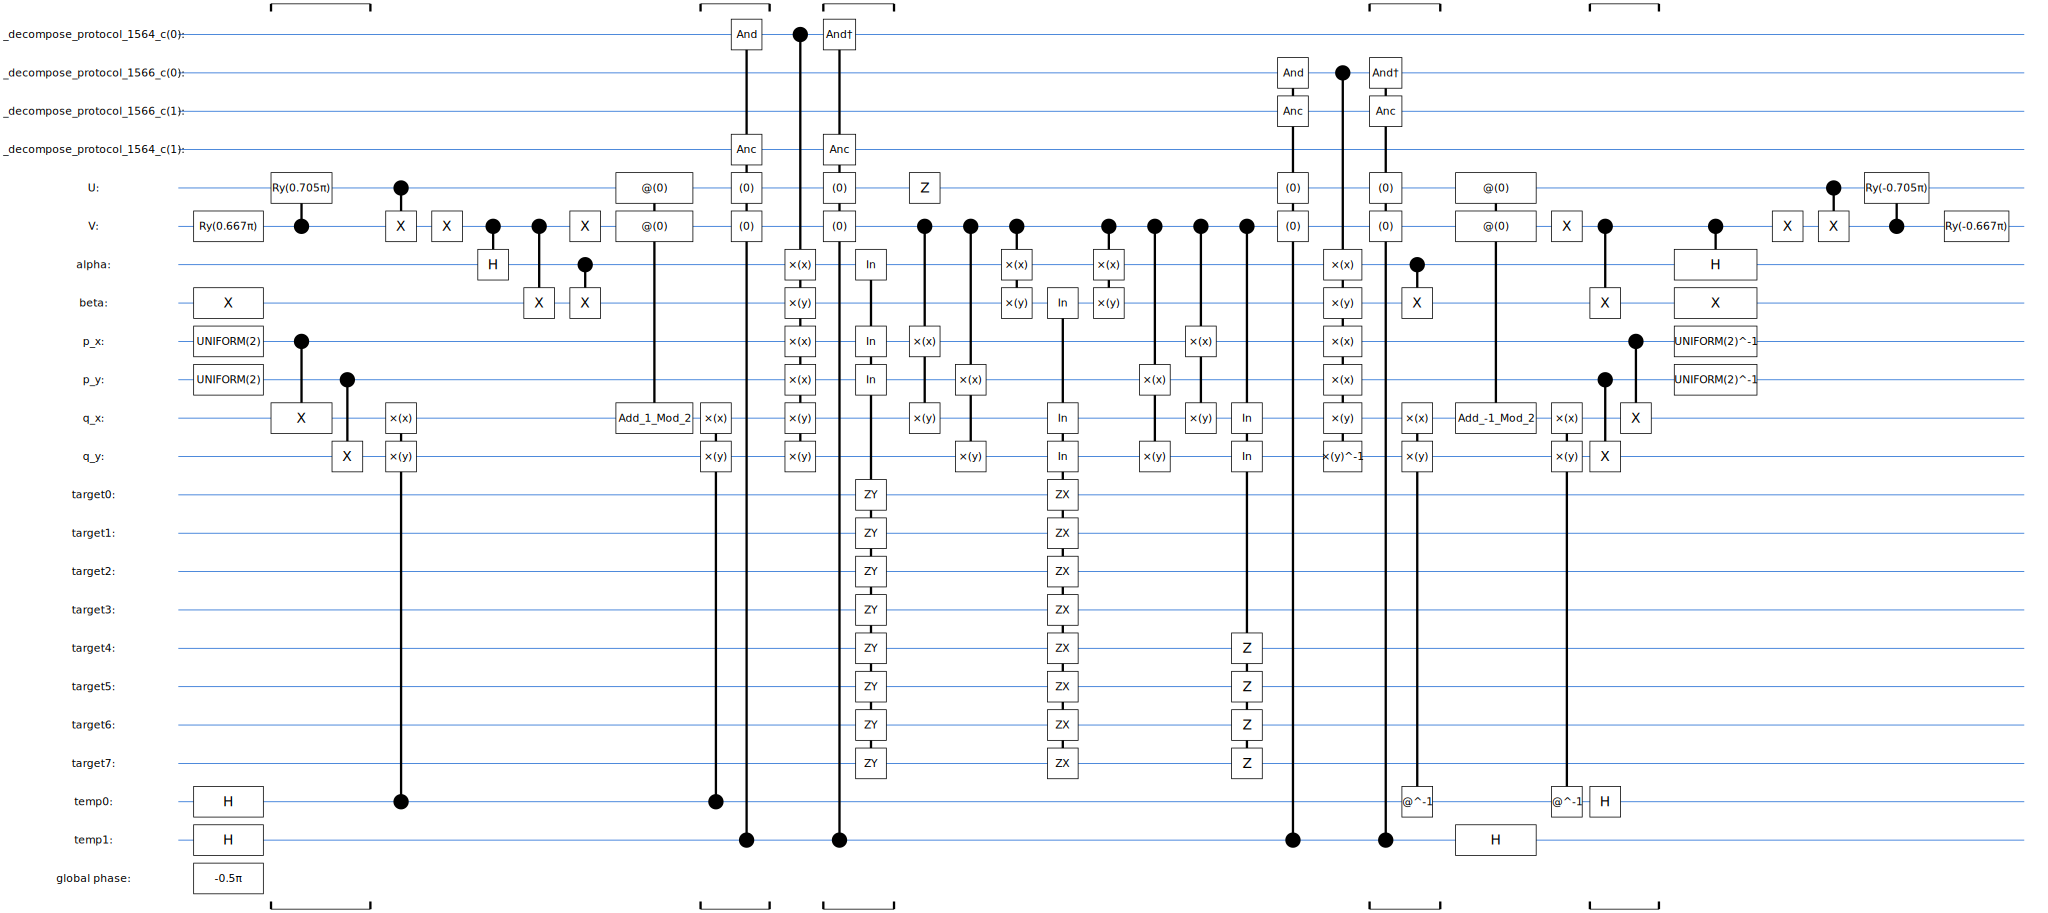

In [18]:
svg_circuit(circuit_decompose_multi(block_encoding.circuit,2))